In [1]:
!pip install pandas scikit-learn torch torch_geometric pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import random
import logging
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

os.environ["JULIA_NUM_THREADS"] = str(min(4, os.cpu_count() or 1))
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from pysr import PySRRegressor

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

def set_seeds(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

def load_data(csv_path: str, features: list, targets: list, test_size=0.2) -> Tuple[Data, StandardScaler, StandardScaler]:
    df = pd.read_csv(csv_path, usecols=features + targets)
    X, y = df[features].values, df[targets].values

    scaler_X = StandardScaler().fit(X)
    scaler_y = StandardScaler().fit(y)
    X_scaled, y_scaled = scaler_X.transform(X), scaler_y.transform(y)

    num_nodes = X.shape[0]
    x = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

    edges = [[i, i + 1] for i in range(num_nodes - 1)] + [[i + 1, i] for i in range(num_nodes - 1)]
    edge_index = torch.tensor(edges, dtype=torch.long).T
    edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)

    idx = np.arange(num_nodes)
    train_idx, test_idx = train_test_split(idx, test_size=test_size, random_state=42)
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    test_mask[test_idx] = True

    data = Data(x=x, edge_index=edge_index, y=y_tensor)
    data.train_mask = train_mask
    data.test_mask = test_mask

    return data, scaler_X, scaler_y

from torch_geometric.nn import MessagePassing

class GNN(MessagePassing):
    def __init__(self, in_dim, latent_dim=3, out_dim=2):
        super().__init__(aggr="add")
        self.msg_net = nn.Sequential(
            nn.Linear(in_dim * 2, 32), nn.Tanh(), nn.Linear(32, latent_dim)
        )
        self.node_net = nn.Sequential(
            nn.Linear(in_dim + latent_dim, 32), nn.Tanh(), nn.Linear(32, out_dim)
        )

    def forward(self, x, edge_index):
        messages = self.propagate(edge_index, x=x)
        return self.node_net(torch.cat([x, messages], dim=-1)), messages

    def message(self, x_i, x_j):
        return self.msg_net(torch.cat([x_i, x_j], dim=-1))


def haversine_loss_torch(y_pred, y_true, scaler_y):
    # y_pred, y_true: [N, 2] (scaled)
    # scaler_y: StandardScaler (fit on [lat, lon])
    means = torch.tensor(scaler_y.mean_, device=y_pred.device, dtype=y_pred.dtype)
    scales = torch.tensor(scaler_y.scale_, device=y_pred.device, dtype=y_pred.dtype)
    y_pred_unscaled = y_pred * scales + means
    y_true_unscaled = y_true * scales + means
    lat1, lon1 = y_true_unscaled[:, 0], y_true_unscaled[:, 1]
    lat2, lon2 = y_pred_unscaled[:, 0], y_pred_unscaled[:, 1]
    lat1 = torch.deg2rad(lat1)
    lat2 = torch.deg2rad(lat2)
    dlat = lat2 - lat1
    dlon = torch.deg2rad(lon2 - lon1)
    a = torch.sin(dlat/2)**2 + torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon/2)**2
    c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
    R = 6371000.
    return torch.mean(R * c)  # mean distance in meters


def train(model, data, optimizer, scaler_y, l1_strength=1e-2, epochs=100):
    model.train()
    best_loss = float('inf')
    patience = 0

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        out, msgs = model(data.x, data.edge_index)

        train_preds = out[data.train_mask]
        train_targets = data.y[data.train_mask]
        loss = haversine_loss_torch(train_preds, train_targets, scaler_y)
        loss += l1_strength * msgs.abs().mean() + 0.01 * msgs.var()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            val_out, _ = model(data.x, data.edge_index)
            val_loss = haversine_loss_torch(
                val_out[data.test_mask], data.y[data.test_mask], scaler_y
            )

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            patience = 0
        else:
            patience += 1
            if patience >= 20:
                break
        model.train()


def run_symbolic_regression(X: np.ndarray, y: np.ndarray) -> PySRRegressor:
    sym = PySRRegressor(
        niterations=100,
        unary_operators=["sin", "cos"],
        binary_operators=["+", "-", "*"],
        model_selection="best",
        multithreading=True,
        maxsize=12,
        maxdepth=4,
        extra_sympy_mappings={"inv": lambda x: 1 / (x + 1e-5)},
    )
    sym.fit(X, y)
    return sym

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def evaluate(lat_true, lon_true, lat_pred, lon_pred):
    dists = haversine_distance(lat_true, lon_true, lat_pred, lon_pred)
    logger.info(f"\n📍 Haversine Error (meters)\nMean: {np.mean(dists):.4f}\nMax : {np.max(dists):.4f}\nMin : {np.min(dists):.4f}")


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    features = ["Accel_X", "Accel_Y", "Accel_Z", "Gyro_X", "Gyro_Y", "Gyro_Z", "Mag_X", "Mag_Y", "Mag_Z", "Heading_deg", "WiFi_RSSI_dBm"]
    targets = ["Latitude", "Longitude"]

    data, scaler_X, scaler_y = load_data("/kaggle/input/gpstest/newdataset.csv", features, targets)

    model = GNN(in_dim=len(features)).to(device)
    data = data.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train(model, data, optimizer, scaler_y)
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    with torch.no_grad():
        outputs, msgs = model(data.x, data.edge_index)

    X_test = data.x[data.test_mask].cpu().numpy()
    y = data.y.cpu().numpy()
    train_idx = data.train_mask.cpu().numpy()
    test_idx = data.test_mask.cpu().numpy()

    X_train = data.x[data.train_mask].cpu().numpy()
    y_train = y[train_idx]
    y_test = y[test_idx]

    sym_lat = run_symbolic_regression(X_train, y_train[:, 0])
    sym_lon = run_symbolic_regression(X_train, y_train[:, 1])

    lat_pred_scaled = sym_lat.predict(X_test)
    lon_pred_scaled = sym_lon.predict(X_test)

    # Reconstruct original scale for proper physical interpretation and evaluation
    lat_true = scaler_y.inverse_transform(np.column_stack([y[test_idx, 0], np.zeros_like(y[test_idx, 0])]))[:, 0]
    lon_true = scaler_y.inverse_transform(np.column_stack([np.zeros_like(y[test_idx, 1]), y[test_idx, 1]]))[:, 1]
    lat_pred = scaler_y.inverse_transform(np.column_stack([lat_pred_scaled, np.zeros_like(lat_pred_scaled)]))[:, 0]
    lon_pred = scaler_y.inverse_transform(np.column_stack([np.zeros_like(lon_pred_scaled), lon_pred_scaled]))[:, 1]

    evaluate(lat_true, lon_true, lat_pred, lon_pred)

    print("\n🔢 Usable Formula for Latitude:")
    print(sym_lat.get_best())
    print("\n🔢 Usable Formula for Longitude:")
    print(sym_lon.get_best())

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.11/dist-packages/pysr/juliapkg.json
[juliapkg] Locating Julia ^1.10.3
[juliapkg] Using Julia 1.10.9 at /usr/local/bin/julia
[juliapkg] Using Julia project at /root/.julia/environments/pyjuliapkg
[juliapkg] Writing Project.toml:
             [deps]
             PythonCall = "6099a3de-0909-46bc-b1f4-468b9a2dfc0d"
             OpenSSL_jll = "458c3c95-2e84-50aa-8efc-19380b2a3a95"
             SymbolicRegression = "8254be44-1295-4e6a-a16d-46603ac705cb"
             Serialization = "9e88b42a-f829-5b0c-bbe9-9e923198166b"
             [compat]
             PythonCall = "=0.9.26"
             OpenSSL_jll = "~3.0"
             SymbolicRegression = "~1.11"
             Serialization = "^1"
[juliapkg] Installing packages:
             import Pkg
             

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed OpenSSL_jll ────────────── v3.0.16+0
   Installed MicroMamba ─────────────── v0.1.14
   Installed Tricks ─────────────────── v0.1.11
   Installed MLJModelInterface ──────── v1.11.1
   Installed JSON3 ──────────────────── v1.14.3
   Installed DynamicExpressions ─────── v1.10.3
   Installed ScientificTypesBase ────── v3.0.0
   Installed PythonCall ─────────────── v0.9.26
   Installed JLLWrappers ────────────── v1.7.1
   Installed ADTypes ────────────────── v1.16.0
   Installed PositiveFactorizations ─── v0.2.4
   Installed Pidfile ────────────────── v1.3.0
   Installed DynamicDiff ────────────── v0.2.1
   Installed ProgressMeter ──────────── v1.10.2
   Installed StatisticalTraits ──────── v3.5.0
   Installed micromamba_jll ─────────── v1.5.12+0
   Installed Optim ──────────────────── v1.13.2
   Installed Compat ─────────────────── v4.18.0
   Installed NLSolversBase ──────────── v7.10

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2858: UserWarning: The `multithreading: bool` parameter has been deprecated in favor of `parallelism: Literal['multithreading', 'serial', 'multiprocessing']`.
Previous usage of `multithreading=True` (default) is now `parallelism='multithreading'`; `multithreading=False, procs=0` is now `parallelism='serial'`; and `multithreading=True, procs={int}` is now `parallelism='multiprocessing', procs={int}`.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.330e+04
Progress: 201 / 3100 total iterations (6.484%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.007e+00  0.000e+00  y = -0.0029453
3           1.007e+00  2.329e-04  y = x₉ * 0.02193
4           1.006e+00  6.818e-04  y = sin(x₄) * 0.074533
5           1.006e+00  3.784e-04  y = (x₁₀ * x₂) * 0.028867
8           1.006e+00  1.015e-05  y = (x₂ * -0.1083) * sin(x₁₀ * -0.27404)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.750e+04
Progress: 354 / 3100 total iterations (11.419%)
══════════════════════════

[ Info: Final population:
[ Info: Results saved to:
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2858: UserWarning: The `multithreading: bool` parameter has been deprecated in favor of `parallelism: Literal['multithreading', 'serial', 'multiprocessing']`.
Previous usage of `multithreading=True` (default) is now `parallelism='multithreading'`; `multithreading=False, procs=0` is now `parallelism='serial'`; and `multithreading=True, procs={int}` is now `parallelism='multiprocessing', procs={int}`.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.440e+04
Progress: 264 / 3100 total iterations (8.516%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           9.979e-01  0.000e+00  y = 0.0030072
3           9.976e-01  1.753e-04  y = x₃ * 0.017227
4           9.974e-01  1.159e-04  y = sin(x₃ * 0.030348)
6           9.970e-01  2.372e-04  y = sin(x₃ * (x₂ * 0.013626))
8           9.966e-01  1.774e-04  y = sin((1.6595 + x₂) * (x₃ * 0.011411))
10          9.960e-01  3.076e-04  y = ((-0.64624 - -1.0079) * -0.64624) * sin(x₃ * x₄)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per s

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           9.979e-01  0.000e+00  y = 0.0030072
3           9.976e-01  1.753e-04  y = x₃ * 0.017227
4           9.974e-01  1.159e-04  y = sin(x₃ * 0.030626)
5           9.974e-01  3.433e-05  y = x₁ * (x₂ * 0.010107)
6           9.960e-01  1.420e-03  y = sin(x₃ * x₄) * -0.25123
───────────────────────────────────────────────────────────────────────────────────────────────────

🔢 Usable Formula for Latitude:
complexity                                                7
loss                                                 1.0051
equation                    ((x2 - x5) * x10) * 0.023196703
score                                              0.000785
sympy_format                      (x2 - x5)*x10*0.023196703
lambda_format    PySRFunction(X=>(x2 - x5)*x10*0.023196703)
Name: 5, dtype: object

🔢 Usable Formula for Longitude:
complexity                     

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
import logging
import tracemalloc
import pickle

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# --- Haversine distance ---
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = phi2 - phi1
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ---- Feature indexing map ----
feature_map = {f: i for i, f in enumerate([
    "Accel_X", "Accel_Y", "Accel_Z", "Gyro_X", "Gyro_Y", "Gyro_Z",
    "Mag_X", "Mag_Y", "Mag_Z", "Heading_deg", "WiFi_RSSI_dBm"
])}

# ---- Symbolic Regression ----
def predict_latitude(X):
    i = feature_map
    return (X[:, i["Accel_Z"]] - X[:, i["Gyro_Z"]]) * X[:, i["WiFi_RSSI_dBm"]] * 0.023196703

def predict_longitude(X):
    i = feature_map
    return np.sin(X[:, i["Gyro_X"]] * X[:, i["Gyro_Y"]]) * -0.2512324

# ---- Real Kalman Filter Implementation ----
class KalmanFilter1D:
    def __init__(self, initial_state, initial_covariance=1.0, process_noise=0.01, measurement_noise=0.1):
        self.x = np.array([[initial_state], [0.0]])  # State vector [pos; velocity]
        self.P = np.array([[initial_covariance, 0], [0, initial_covariance]])
        dt = 1.0
        self.F = np.array([[1.0, dt], [0.0, 1.0]])  # State transition
        self.H = np.array([[1.0, 0.0]])  # Measurement function
        self.Q = np.array([[process_noise, 0], [0, process_noise]])  # Process noise cov.
        self.R = np.array([[measurement_noise]])  # Measurement noise cov.

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, measurement):
        y = measurement - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = self.P - K @ self.H @ self.P

    def get_state(self):
        return self.x[0, 0]

def kalman_smooth_1d(values):
    kf = KalmanFilter1D(values[0])
    smoothed = []
    for val in values:
        kf.predict()
        kf.update(val)
        smoothed.append(kf.get_state())
    return np.array(smoothed)

# ---- Utility to estimate model memory usage by pickling ----
def get_model_memory_mb(model):
    try:
        model_bytes = pickle.dumps(model)
        mem_mb = len(model_bytes) / (1024 * 1024)
        return mem_mb
    except Exception as e:
        logger.warning(f"Failed to estimate memory via pickle: {e}")
        return float('nan')

# ---- Memory tracking and model training ----
def train_and_eval_model(name, model, X_train, y_train, X_test, y_test, scaler_y):
    import copy
    logger.info(f"Training {name}...")
    tracemalloc.start()
    if y_train.ndim == 2 and y_train.shape[1] > 1:
        model_wrapped = MultiOutputRegressor(copy.deepcopy(model))
        model_wrapped.fit(X_train, y_train)
        mem_mb = get_model_memory_mb(model_wrapped)
        pred_scaled = model_wrapped.predict(X_test)
    else:
        model.fit(X_train, y_train)
        mem_mb = get_model_memory_mb(model)
        pred_scaled = model.predict(X_test)
    tracemalloc.stop()

    if pred_scaled.ndim == 1:
        pred_scaled = pred_scaled.reshape(-1, 1)
    if pred_scaled.shape[1] == 2:
        pred_lat = scaler_y.inverse_transform(
            np.column_stack([pred_scaled[:, 0], np.zeros(len(pred_scaled))])
        )[:, 0]
        pred_lon = scaler_y.inverse_transform(
            np.column_stack([np.zeros(len(pred_scaled)), pred_scaled[:, 1]])
        )[:, 1]
    else:
        pred_lat, pred_lon = None, None

    if pred_lat is not None and pred_lon is not None:
        dists = haversine_distance(y_test[:, 0], y_test[:, 1], pred_lat, pred_lon)
        mean_dist = np.mean(dists)
    else:
        mean_dist = float('nan')

    logger.info(f"{name} Mean Haversine Loss: {mean_dist:.4f} meters | Model Memory Usage: {mem_mb:.6f} MB")
    return {'Model': name, 'Memory_MiB': mem_mb, 'Haversine_loss_mean_m': mean_dist}

# ---- Main Script ----
def main():
    features = ["Accel_X", "Accel_Y", "Accel_Z", "Gyro_X", "Gyro_Y", "Gyro_Z",
                "Mag_X", "Mag_Y", "Mag_Z", "Heading_deg", "WiFi_RSSI_dBm"]
    targets = ["Latitude", "Longitude"]
    csv_path = "/kaggle/input/gpstest/newdataset.csv"  # Update as needed

    df = pd.read_csv(csv_path, usecols=features + targets)
    X = df[features].values
    y = df[targets].values

    scaler_X = StandardScaler().fit(X)
    scaler_y = StandardScaler().fit(y)
    X_scaled = scaler_X.transform(X)
    y_scaled = scaler_y.transform(y)

    idx = np.arange(len(X))
    train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)
    X_train, y_train = X_scaled[train_idx], y_scaled[train_idx]
    X_test, y_test = X_scaled[test_idx], y[test_idx]  # Real values for eval

    # Symbolic Regression
    lat_pred_sr = predict_latitude(X_test)
    lon_pred_sr = predict_longitude(X_test)
    lat_pred_sr_real = scaler_y.inverse_transform(np.column_stack([lat_pred_sr, np.zeros_like(lat_pred_sr)]))[:, 0]
    lon_pred_sr_real = scaler_y.inverse_transform(np.column_stack([np.zeros_like(lon_pred_sr), lon_pred_sr]))[:, 1]
    dists_sr = haversine_distance(y_test[:, 0], y_test[:, 1], lat_pred_sr_real, lon_pred_sr_real)
    mean_dist_sr = np.mean(dists_sr)
    mem_sr = (lat_pred_sr.nbytes + lon_pred_sr.nbytes) / (1024 * 1024)

    logger.info(f"Symbolic Regression Mean Haversine Loss: {mean_dist_sr:.4f} meters | Memory Usage (output arrays): {mem_sr:.6f} MB")

    # Kalman Filter
    kalman_lat = kalman_smooth_1d(y_test[:, 0])
    kalman_lon = kalman_smooth_1d(y_test[:, 1])
    kalman_loss = np.mean(haversine_distance(y_test[:, 0], y_test[:, 1], kalman_lat, kalman_lon))
    mem_kalman = (kalman_lat.nbytes + kalman_lon.nbytes) / (1024 * 1024)

    logger.info(f"Kalman Filter Mean Haversine Loss: {kalman_loss:.4f} meters | Memory Usage (output arrays): {mem_kalman:.6f} MB")

    results = []
    models = [
        ('Linear Regression', LinearRegression()),
        ('Random Forest', RandomForestRegressor()),
        ('MLP', MLPRegressor(max_iter=300)),
        ('Decision Tree', DecisionTreeRegressor())
    ]
    for name, mdl in models:
        stats = train_and_eval_model(name, mdl, X_train, y_train, X_test, y_test, scaler_y)
        results.append(stats)

    results.append({'Model': 'Symbolic Regression', 'Memory_MiB': mem_sr, 'Haversine_loss_mean_m': mean_dist_sr})
    results.append({'Model': 'Kalman Filter', 'Memory_MiB': mem_kalman, 'Haversine_loss_mean_m': kalman_loss})

    print("\nModel Performance (Model Memory & Mean Haversine Loss in meters):")
    print("| Model                      | Model Memory (MiB)  | Mean Haversine Loss (meters) |")
    print("|----------------------------|--------------------|------------------------------|")
    for r in results:
        print(f"| {r['Model']:<26} | {r['Memory_MiB']:<18.6f} | {r['Haversine_loss_mean_m']:<28.4f} |")

    print("\nSample predictions [true_lat, true_lon] vs [SR_lat, SR_lon]:")
    for i in range(min(5, len(y_test))):
        print(f"GT : ({y_test[i,0]:.6f}, {y_test[i,1]:.6f}) | "
              f"SR : ({lat_pred_sr_real[i]:.6f}, {lon_pred_sr_real[i]:.6f})")

if __name__ == "__main__":
    main()



Model Performance (Model Memory & Mean Haversine Loss in meters):
| Model                      | Model Memory (MiB)  | Mean Haversine Loss (meters) |
|----------------------------|--------------------|------------------------------|
| Linear Regression          | 0.000950           | 16.7563                      |
| Random Forest              | 103.683737         | 16.9078                      |
| MLP                        | 0.067510           | 16.7962                      |
| Decision Tree              | 1.640881           | 23.1397                      |
| Symbolic Regression        | 0.025620           | 16.7532                      |
| Kalman Filter              | 0.025620           | 9.1428                       |

Sample predictions [true_lat, true_lon] vs [SR_lat, SR_lon]:
GT : (13.087916, 80.278368) | SR : (13.087799, 80.278484)
GT : (13.087786, 80.278530) | SR : (13.087799, 80.278500)
GT : (13.087841, 80.278320) | SR : (13.087798, 80.278502)
GT : (13.087805, 80.278574) | SR

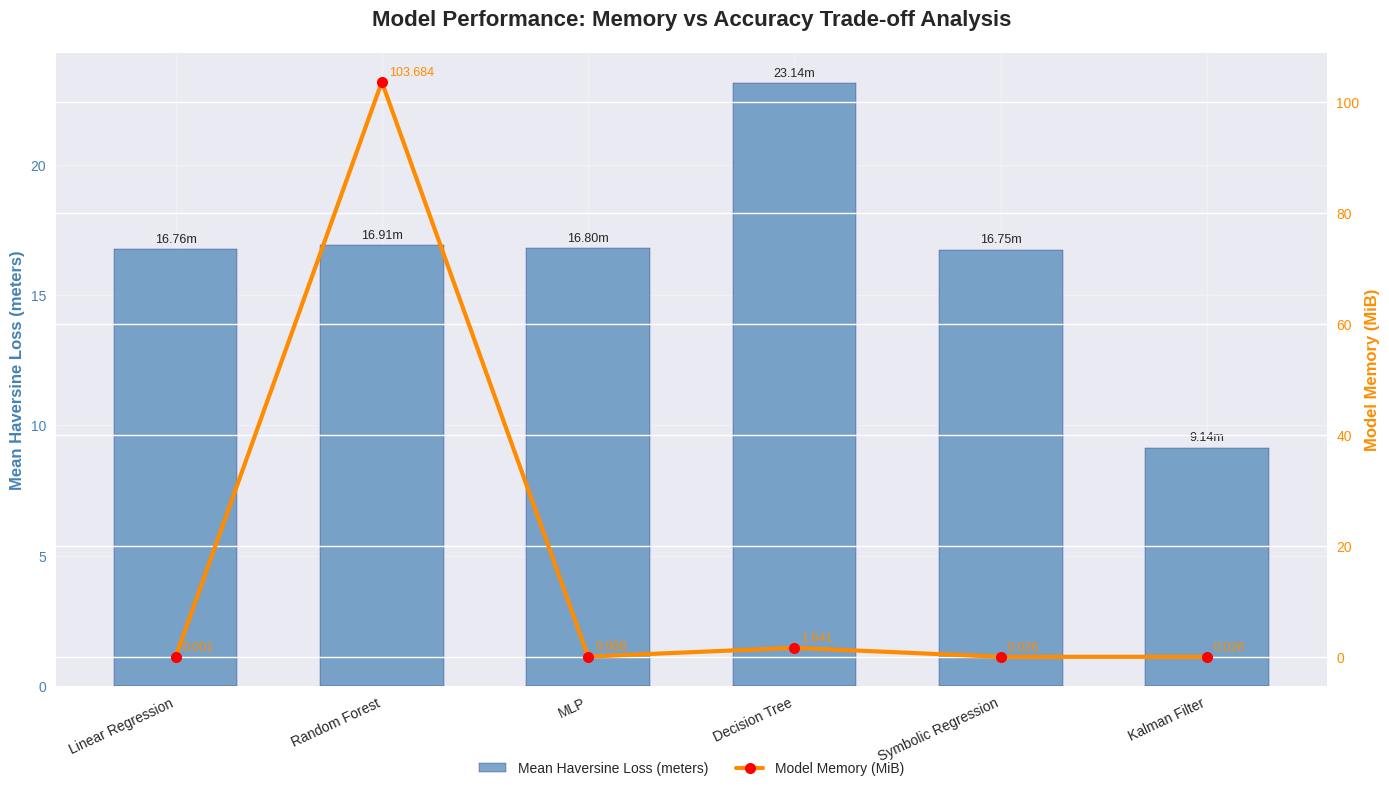

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["Linear Regression", "Random Forest", "MLP", "Decision Tree", 
          "Symbolic Regression", "Kalman Filter"]
mean_haversine_loss = [16.7563, 16.9078, 16.7962, 23.1397, 16.7532, 9.1428]
model_memory = [0.000950, 103.683737, 0.067510, 1.640881, 0.025620, 0.025620]

# Styling
plt.style.use('seaborn-v0_8')
fig, ax1 = plt.subplots(figsize=(14, 8))

x = np.arange(len(models))

# Bar plot: Haversine loss
bars = ax1.bar(x, mean_haversine_loss, width=0.6, color='steelblue', 
               label='Mean Haversine Loss (meters)', alpha=0.7, edgecolor='navy')

# Annotate bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}m',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# Left y-axis config
ax1.set_ylabel('Mean Haversine Loss (meters)', fontsize=12, fontweight='bold', color='steelblue')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=25, ha='right')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Secondary axis: Model memory
ax2 = ax1.twinx()
line = ax2.plot(x, model_memory, color='darkorange', marker='o', 
                label='Model Memory (MiB)', linewidth=3, markersize=8, markerfacecolor='red')

# Annotate line points
for i, (xi, yi) in enumerate(zip(x, model_memory)):
    ax2.annotate(f'{yi:.3f}', xy=(xi, yi), xytext=(5, 5), 
                 textcoords='offset points', fontsize=9, color='darkorange')

# Right y-axis config
ax2.set_ylabel('Model Memory (MiB)', fontsize=12, fontweight='bold', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Title and legend
plt.title('Model Performance: Memory vs Accuracy Trade-off Analysis', 
          fontsize=16, fontweight='bold', pad=20)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', 
           bbox_to_anchor=(0.5, -0.1), ncol=2)

# Grid and layout
ax1.grid(True, alpha=0.3)
plt.tight_layout()

# Save to Kaggle working directory in 300 DPI
plt.savefig("/kaggle/working/model_tradeoff_analysis.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()


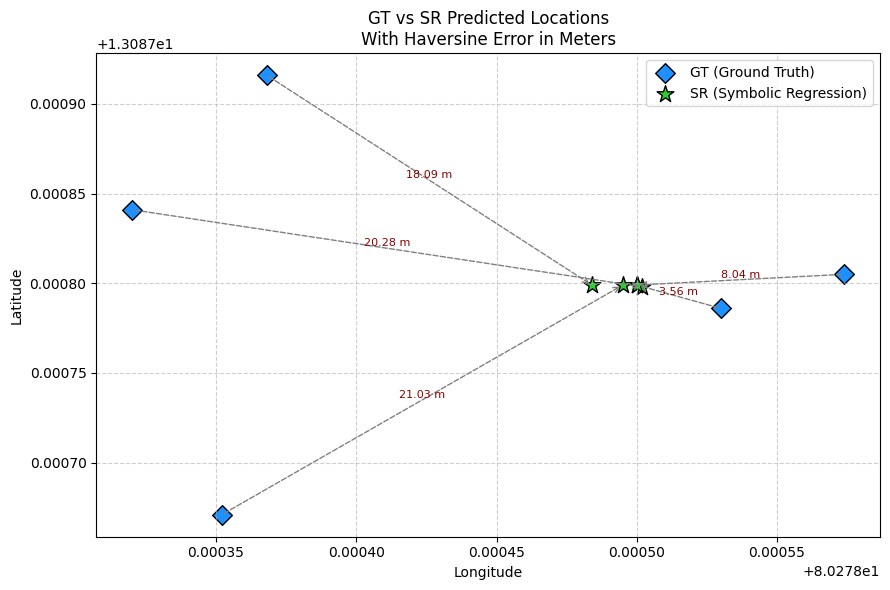

In [6]:
import matplotlib.pyplot as plt
import math

# Ground Truth (GT) and Symbolic Regression (SR) coordinates
gt_coords = [
    (13.087916, 80.278368),
    (13.087786, 80.278530),
    (13.087841, 80.278320),
    (13.087805, 80.278574),
    (13.087671, 80.278352)
]

sr_coords = [
    (13.087799, 80.278484),
    (13.087799, 80.278500),
    (13.087798, 80.278502),
    (13.087799, 80.278500),
    (13.087799, 80.278495)
]

# Custom haversine function (in meters)
def haversine_distance(coord1, coord2):
    R = 6371000  # Earth's radius in meters
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# Compute Haversine distances
distances = [haversine_distance(gt, sr) for gt, sr in zip(gt_coords, sr_coords)]

# Split into lat/lon
gt_lat, gt_lon = zip(*gt_coords)
sr_lat, sr_lon = zip(*sr_coords)

# Plotting
plt.figure(figsize=(9, 6))
plt.scatter(gt_lon, gt_lat, label='GT (Ground Truth)', color='dodgerblue',
            marker='D', s=100, edgecolor='black')
plt.scatter(sr_lon, sr_lat, label='SR (Symbolic Regression)', color='limegreen',
            marker='*', s=160, edgecolor='black')

# Arrows and labels
for i in range(len(gt_coords)):
    plt.annotate("",
                 xy=(sr_lon[i], sr_lat[i]),
                 xytext=(gt_lon[i], gt_lat[i]),
                 arrowprops=dict(arrowstyle="->", color="gray", linestyle="--"))
    plt.text((gt_lon[i] + sr_lon[i]) / 2,
             (gt_lat[i] + sr_lat[i]) / 2,
             f"{distances[i]:.2f} m",
             fontsize=8,
             color='darkred',
             ha='center',
             va='bottom')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GT vs SR Predicted Locations\nWith Haversine Error in Meters")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save for Kaggle
plt.savefig("gt_vs_sr_haversine.png", dpi=300)
plt.show()
